# TABLE OF CONTENTS
### [OVERVIEW OF OSEMiNl](#OVERVIEW-OF-OSEMiN)
- [OBTAIN](#OBTAIN) 
- [SCRUB](#SCRUB) 
- [EXPLORE](#EXPLORE) 
- [MODEL](#MODEL) 
- [iNTERPRET](#iNTERPRET) 

### [CONCLUSIONS & RECOMMENDATIONS](#CONCLUSIONS-&-RECOMMENDATIONS)
___

# OVERVIEW OF OSEMiN


<img src='https://raw.githubusercontent.com/learn-co-curriculum/online-ds-ft-100719/master/osemind.png?token=AKWNGY6ANK33DJDTWNP7OOK5WTWRU' width=800>
<center><a href="https://www.kdnuggets.com/2018/02/data-science-command-line-book-exploring-data.html">Source: KDNuggets</a></center>

>  The Data Science Process we'll be using during this section--OSEMiN (pronounced "OH-sum", rhymes with "possum").  This is the most straightforward of the Data Science Processes discussed so far.  **Note that during this process, just like the others, the stages often blur together.***  It is completely acceptable (and ***often a best practice!) to float back and forth** between stages as you learn new things about your problem, dataset, requirements, etc.  
>  It's quite common to get to the modeling step and realize that you need to scrub your data a bit more or engineer a different feature and jump back to the "Scrub" stage, or go all the way back to the "Obtain" stage when you realize your current data isn't sufficient to solve this problem. 
As with any of these frameworks, *OSEMiN is meant to be treated as guidelines, not law. 

- **[OBTAIN](#OBTAIN)**

This step involves understanding stakeholder requirements, gathering information on the problem, and finally sourcing data that we think will be necessary for solving this problem. 

- **[SCRUB](#SCRUB)**

During this stage, we'll focus on preprocessing our data.  Important steps such as identifying and removing null values, dealing with outliers, normalizing data, and feature engineering/feature selection are handled around this stage.  The line with this stage really blurs with the _Explore_ stage, as it is common to only realize that certain columns require cleaning or preprocessing as a result of the visualzations and explorations done during Step 3.  

Note that although technically, categorical data should be one-hot encoded during this step, in practice, it's usually done after data exploration.  This is because it is much less time-consuming to visualize and explore a few columns containing categorical data than it is to explore many different dummy columns that have been one-hot encoded. 

- **[EXPLORE](#EXPLORE)**

This step focuses on getting to know the dataset you're working with. As mentioned above, this step tends to blend with the _Scrub_ step mentioned above.  During this step, you'll create visualizations to really get a feel for your dataset.  You'll focus on things such as understanding the distribution of different columns, checking for multicollinearity, and other tasks liek that.  If your project is a classification task, you may check the balance of the different classes in your dataset.  If your problem is a regression task, you may check that the dataset meets the assumptions necessary for a regression task.  

At the end of this step, you should have a dataset ready for modeling that you've thoroughly explored and are extremely familiar with.  

- **[MODEL](#MODEL)**

This step, as with the last two frameworks, is also pretty self-explanatory. It consists of building and tuning models using all the tools you have in your data science toolbox.  In practice, this often means defining a threshold for success, selecting machine learning algorithms to test on the project, and tuning the ones that show promise to try and increase your results.  As with the other stages, it is both common and accepted to realize something, jump back to a previous stage like _Scrub_ or _Explore_, and make some changes to see how it affects the model.  

- **[iNTERPRET](#iNTERPRET)**

During this step, you'll interpret the results of your model(s), and communicate results to stakeholders.  As with the other frameworks, communication is incredibily important! During this stage, you may come to realize that further investigation is needed, or more data.  That's totally fine--figure out what's needed, go get it, and start the process over! If your results are satisfactory to all stakeholders involved, you may also go from this stage right into productionizing your model and automating processes necessary to support it.  


## Additional Links
* ML models google sheet https://docs.google.com/spreadsheets/d/1qe4nYjGKSxBNCkeV2gxxgObBpKKc0TKrbk0Y9LTrpV8
* How to detect and remove outliers:
    * https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba
* How to handle categorical variables. 
    * https://towardsdatascience.com/understanding-feature-engineering-part-2-categorical-data-f54324193e63
* Sci-Kit Learn’s Scalers visually explained 
    * http://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html

# PROCESS CHECKLIST

1. **OBTAIN:**
    - Import data, inspect, check for datatypes to convert and null values
    - Display header and info.
    - Drop any unneeded columns, if known (`df.drop(['col1','col2'],axis=1,inplace=True`)
    <br><br>

2. **SCRUB: cast data types, identify outliers, check for multicollinearity, normalize data**
    - Check and cast data types
        - [ ] Check for #'s that are store as objects (`df.info()`,`df.describe()`)
            - when converting to #'s, look for odd values (like many 0's), or strings that can't be converted.
            - Decide how to deal weird/null values (`df.unique()`, `df.isna().sum()`)
            - `df.fillna(subset=['col_with_nulls'],'fill_value')`, `df.replace()`
        - [ ]  Check for categorical variables stored as integers.
            - May be easier to tell when you make a scatter plotm or `pd.plotting.scatter_matrix()`
    - [ ] Check for missing values  (df.isna().sum())
        - Can drop rows or colums
        - For missing numeric data with median or bin/convert to categorical
        - For missing categorical data: make NaN own category OR replace with most common category
    - [ ] Check for multicollinearity
        - Use seaborn to make correlation matrix plot 
        - Good rule of thumb is anything over 0.75 corr is high, remove the variable that has the most correl with the largest # of variables
    - [ ] Normalize data (may want to do after some exploring)
        - Most popular is Z-scoring (but won't fix skew) 
        - Can log-transform to fix skewed data
    
            
3. **EXPLORE:Check distributions, outliers, etc**
    - [ ] Check scales, ranges (df.describe())
    - [ ] Check histograms to get an idea of distributions (df.hist()) and data transformations to perform.
        - Can also do kernel density estimates
    - [ ] Use scatter plots to check for linearity and possible categorical variables (`df.plot("x","y")`)
        - categoricals will look like vertical lines
    - [ ] Use `pd.plotting.scatter_matrix(df)` to visualize possible relationships
    - [ ] Check for linearity.
   
4. **FIT AN INITIAL MODEL:** 
    - Various forms, detail later...
    - **Assessing the model:**
        - Assess parameters (slope,intercept)
        - Check if the model explains the variation in the data (RMSE, F, R_square)
        - *Are the coeffs, slopes, intercepts in appropriate units?*
        - *Whats the impact of collinearity? Can we ignore?*
        <br><br>
5. **Revise the fitted model**
    - Multicollinearity is big issue for lin regression and cannot fully remove it
    - Use the predictive ability of model to test it (like R2 and RMSE)
    - Check for missed non-linearity
6. **Holdout validation / Train/test split**
    - use sklearn train_test_split 
___

In [1]:
# PyPi package for cohort
# !pip install -U fsds_100719 # comment out after install so it won't run again

# OBTAIN

In [2]:
!pip install -U fsds_100719
import IPython.display as disp
disp.clear_output()

In [3]:
# Shortcut import of 
# import pandas as pd, numpy as np, etc...
import fsds_100719 as fs
from fsds_100719.imports import *

fsds_1007219  v0.4.8 loaded.  Read the docs: https://fsds.readthedocs.io/en/latest/ 
> For convenient loading of standard modules use: `>> from fsds_100719.imports import *`



Package,Handle,Description
IPython.display,dp,Display modules with helpful display and clearing commands.
fsds_100719,fs,Custom data science bootcamp student package
matplotlib,mpl,Matplotlib's base OOP module with formatting artists
matplotlib.pyplot,plt,Matplotlib's matlab-like plotting module
numpy,np,scientific computing with Python
pandas,pd,High performance data structures and tools
seaborn,sns,High-level data visualization library based on matplotlib


In [4]:
%ls

CONTRIBUTING.md             draft_files/
LICENSE.md                  kc_house_data.csv
OSEMIN_scaffolding.ipynb    module1_project_rubric.pdf
README.md                   student.ipynb
awesome.gif                 student_legacy.ipynb
column_names.md             study_group_starter.ipynb
draft.htm


In [5]:
df = pd.read_csv('kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


## Define Functions

In [6]:
# Check columns returns the datatype, null values and unique values of input series 
def check_column(series_feature, series_target=None, max_unique=10,
                 nbins = None):
    """Takes a series from a dataframe (df[col]), 
    reports back info on unique values, nulls, .describe() stats.
    
    
    Args:
        series (series (DataFrame column)): column to report    
    """
    dashes = '---'*25
    series=series_feature
    
    
    print(dashes)
    
    print(f"series dtype is {series.dtype}\n")
    print(f'- Unique Values for {series.name}')
    display(series.value_counts(bins = nbins))#[0:max_unique])#[:max_unique])
    
    print('n- Null Values ')
    nulls = series.isna().sum()
    print(nulls)
    
    print('\n\tDescribe')
    print(series.describe())
    
    if series.dtype != 'object':
        fig, axes = plt.subplots(figsize=(15, 5), ncols=2, nrows=1)
        axes[0].set_title(f"Showing {series_target.name}")
        axes[0].set_title(series.name)
        sns.distplot(series, ax = axes[0])
    else:
        print(f"{series.name} is a string column and cannot be plotted")

    if series_target is not None: 
        axes[1].set_title(f"{series_feature.name} vs {series_target.name} (in thousands)")
        sns.scatterplot(series_feature, series_target, ax = axes[1])

In [7]:
def upper_outliers(feature, std_multiplier = 2) :
    """ Takes a series or a dataframe as a feaature and provides feedback on 
    the following:
    
    The feature's mean value
    The value of a given standard deviation
    A count of records above that value
    The percent of total records above that value.
    
    Parameters
    ----------
    feature : series or dataframe
    std_multiplier : integer, default 3, used to by specify how my times 
    to multiply the standard deviation to reach the final figure.
    
    The purpose of this function is to provide insight about a feature's number
    of records beyond a certain point relative to standard deviation before
    invoking function cut_outliers.
    """
    feature_std_xx = round(feature.mean() + (feature.std()*std_multiplier), 2)
    feature_cut = df.loc[df[feature.name] > feature_std_xx][feature.name]
    outside_std_count = feature_cut.count()
    pct_outside_std = round(outside_std_count / feature.count(), 2)
    print(f'Mean feature value is: {round(feature.mean(),2)}')
    print(f'{std_multiplier}x standard deviation cutoff: {feature_std_xx}')
    print(f'Records above {std_multiplier}x standard deviation: {outside_std_count}')
    print(f'Percent of records above {std_multiplier}x standard deviation: {pct_outside_std}')

In [8]:
def cut_upper_outliers(feature, std_multiplier):
    """Takes a series or dataframe and returns a series with all records cut
    out above the standard deviation multiplied as specified in argument.
    
    Parameters
    ----------
    feature : series or dataframe
    std_multiplier : integer, default 3, used to by specify how my times 
    to multiply the standard deviation to reach the final figure.
    """  
    
    feature_std_xx = round(feature.mean() + (feature.std()*std_multiplier), 2)
    return df.loc[df[feature.name] < feature_std_xx][feature.name]

In [9]:
# I'm going to need this later on when I'm trying to re-transform the prediction
# values.
original_latmax = df['lat'].max()
original_latmin = df['lat'].min()

# SCRUB

In [10]:
# Ignore pink warnings 
import warnings
warnings.filterwarnings('ignore')

# Allow for a large # of columns
pd.set_option('display.max_columns',0)
# pd.set_option('display.max_rows','')

## Information Overview

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


In [12]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


## Cleaning Data

In [13]:
# scaling price to make it more readable.
df['price'] = df['price'] / 1000

In [14]:
# Starting to get rid of unnecessary columns and data.
df = df.drop(['id'], axis = 1)

In [15]:
#Proceeding to find null values and figure out 
# what to do with those.

In [16]:
df.isna().sum()

date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [17]:
# So it looks like the only offenders are waterfrom and yr_renovated. It actually makes sense not
# to have values for a lot of those, since most records would not have information for them that would apply.
# Still, those that have values are a small percentage of the total. I'll keep the data for now, 
# assuming the possibility that the presense of values in these columns could be relevant. 
# Anyway, let's take a closer look.

In [18]:
df['waterfront'] = df['waterfront'].fillna(0)

In [19]:
df.isna().sum()

date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront          0
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [20]:
# There seems to be no consensus on the value of "view," so I'll drop that too."
df = df.drop(['view'], axis = 1)

---------------------------------------------------------------------------
series dtype is float64

- Unique Values for waterfront


0.0    21451
1.0      146
Name: waterfront, dtype: int64

n- Null Values 
0

	Describe
count    21597.000000
mean         0.006760
std          0.081944
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: waterfront, dtype: float64


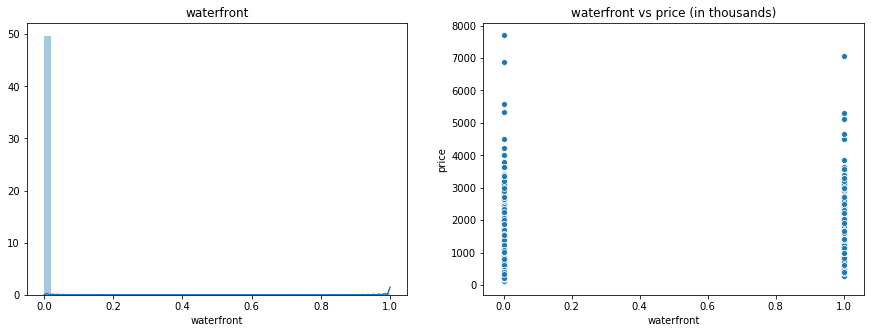

In [21]:
check_column(df['waterfront'], df['price'])

---------------------------------------------------------------------------
series dtype is float64

- Unique Values for yr_renovated


(-2.016, 403.0]     17011
(1612.0, 2015.0]      744
(1209.0, 1612.0]        0
(806.0, 1209.0]         0
(403.0, 806.0]          0
Name: yr_renovated, dtype: int64

n- Null Values 
3842

	Describe
count    17755.000000
mean        83.636778
std        399.946414
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       2015.000000
Name: yr_renovated, dtype: float64


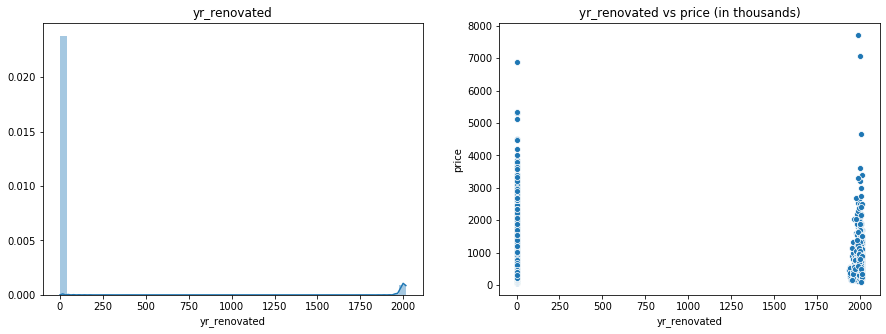

In [22]:
check_column(df['yr_renovated'], df['price'], nbins = 5)

In [23]:
# The data here is jumbled. It's most likely dates that are coded in some other
# way that's not being recognized. Would love to come back to it, if only to
# create a sample subset of the renovated data, but I might not have time.

---------------------------------------------------------------------------
series dtype is int64

- Unique Values for bedrooms


(0.967, 7.4]    21573
(7.4, 13.8]        23
(26.6, 33.0]        1
(20.2, 26.6]        0
(13.8, 20.2]        0
Name: bedrooms, dtype: int64

n- Null Values 
0

	Describe
count    21597.000000
mean         3.373200
std          0.926299
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         33.000000
Name: bedrooms, dtype: float64


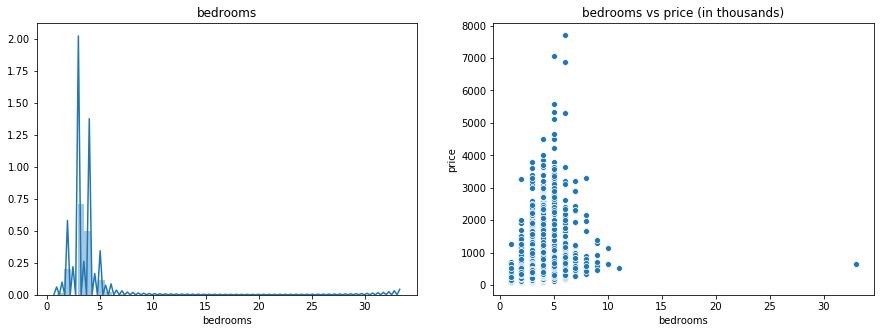

In [24]:
df['bedrooms'] = df['bedrooms'].fillna(0)
check_column(df['bedrooms'], df['price'], nbins = 5)

In [25]:
df['bedrooms'].isna().sum()

0

# EXPLORE

---------------------------------------------------------------------------
series dtype is int64

- Unique Values for sqft_living


(1687.0, 3004.0]      10166
(356.829, 1687.0]      8354
(3004.0, 4321.0]       2580
(4321.0, 5638.0]        395
(5638.0, 6955.0]         72
(6955.0, 8272.0]         23
(9589.0, 10906.0]         3
(8272.0, 9589.0]          2
(12223.0, 13540.0]        1
(10906.0, 12223.0]        1
Name: sqft_living, dtype: int64

n- Null Values 
0

	Describe
count    21597.000000
mean      2080.321850
std        918.106125
min        370.000000
25%       1430.000000
50%       1910.000000
75%       2550.000000
max      13540.000000
Name: sqft_living, dtype: float64


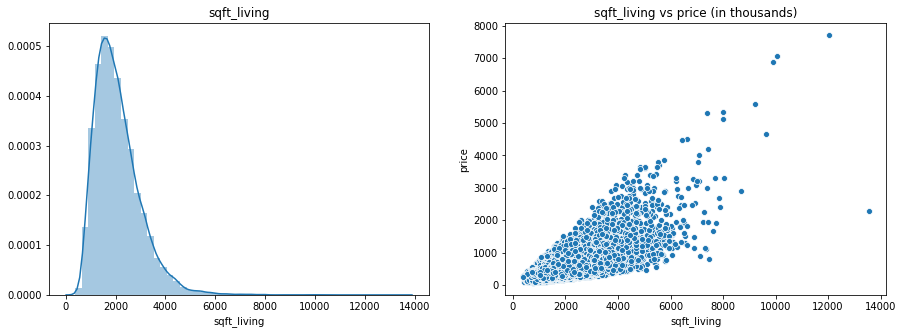

In [26]:
#Check the most obvious factor.

check_column(df['sqft_living'], df['price'], nbins = 10)

In [27]:
df.isna().sum()

date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront          0
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

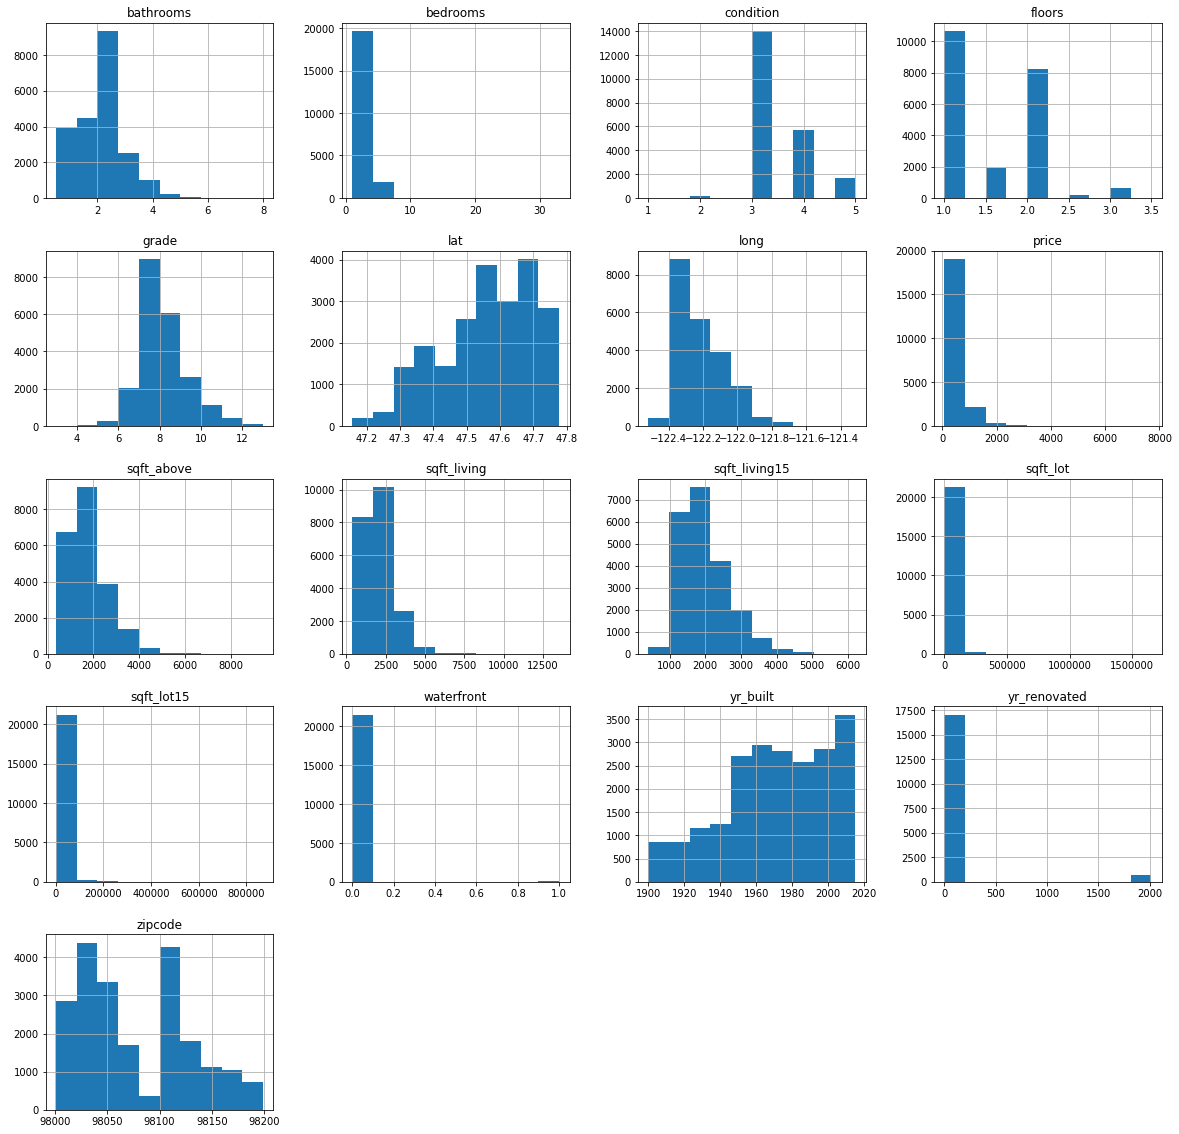

In [28]:
df.hist(figsize=(20,20));

In [29]:
# pd.plotting.scatter_matrix(df, figsize=(20,20));
# Commenting out to save computing time during re-runs.

## Handle outliers

In [30]:
# Before getting into normalizing and all that, I think there are some 
# extreme outliers here that can make our histograms look tons better.

In [31]:
df['price'].value_counts(bins = 3)

(70.377, 2618.667]      21515
(2618.667, 5159.333]       76
(5159.333, 7700.0]          6
Name: price, dtype: int64

In [32]:
# All homes above about $1.6M make up only 2% of the total set. And  yet 
# the mean price is only $540K. I'll get rid rid of that far-end 2%. 

# I mean, one of those houses could have belonged to Kurt Cobain, throwing
# off the whole curve.

In [33]:
# Maybe I'll work on the standard deviation.  This is where I decided to create
# the 'upper_outliers' and 'cut_upper_outliers' functions above.

In [34]:
# upper_outliers(df['price'], 3)

In [35]:
price = cut_upper_outliers(df['price'], 3)
upper_outliers(df['price'], 3)

Mean feature value is: 540.3
3x standard deviation cutoff: 1642.4
Records above 3x standard deviation: 406
Percent of records above 3x standard deviation: 0.02


In [36]:
upper_outliers(df['sqft_living'], 3)

Mean feature value is: 2080.32
3x standard deviation cutoff: 4834.64
Records above 3x standard deviation: 248
Percent of records above 3x standard deviation: 0.01


In [37]:
# df['sqft_living'] = cut_upper_outliers(df['sqft_living'], 3)
# upper_outliers(df['sqft_living'], 3)

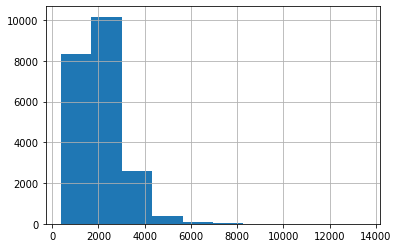

In [38]:
df['sqft_living'].hist()

In [39]:
# check_column(df['view'], df['price'])

In [40]:
# There are a lot of zeros in this result. Since few people would view a home without seeing it first,
# data is assumed to be missing and the zeros are placeholders. Due to the scope, it is presumed this
# series has insufficient information and can be discarded.

In [41]:
# And away it goes.
# df = df.drop(['view'], axis = 1)

In [42]:
abs(df.corr()>.75)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
price,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bedrooms,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,True,True,False,False,False,False,True,True,False,False,False,False,False,True,False
sqft_lot,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
floors,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
grade,False,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False,False
sqft_above,False,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False,False


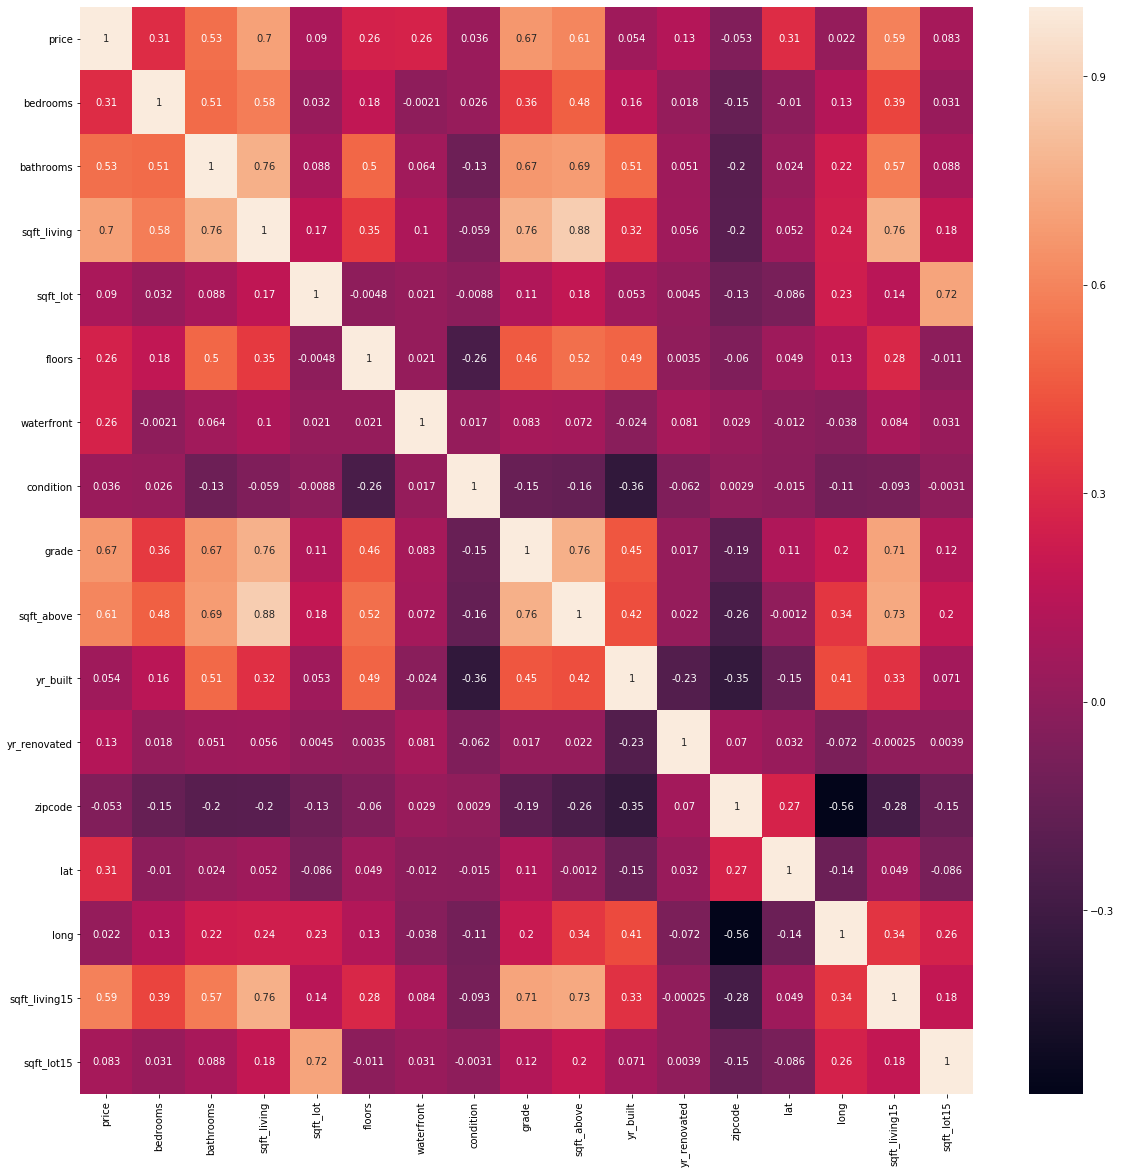

In [43]:
plt.subplots(figsize=(20,20))
sns.heatmap(df.corr(), annot = True)

In [44]:
# Based on the above charts showing correlations, I will remove the following variables
# with correlaations over .75 to avoid multicolinearity convlicts:
# bathrooms, sqft_above, grade, sqft_living15, which all correlate with sqft_living.
# The presumption is that the square footage of living space is the driving factor behind the 
# other features, and those factors will only cause correlation conflicts if used in any meaningful analyses.

In [45]:
# Suspending drop while I work on some other values.

# df = df.drop(['bathrooms', 'grade', 'sqft_above', 'sqft_living15'], axis = 1)
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,10/13/2014,221.9,3,1.00,1180,5650,1.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,12/9/2014,538.0,3,2.25,2570,7242,2.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,2/25/2015,180.0,2,1.00,770,10000,1.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,12/9/2014,604.0,4,3.00,1960,5000,1.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,2/18/2015,510.0,3,2.00,1680,8080,1.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


---------------------------------------------------------------------------
series dtype is float64

- Unique Values for long


(-122.278, -122.037]    9546
(-122.521, -122.278]    9247
(-122.037, -121.797]    2569
(-121.797, -121.556]     218
(-121.556, -121.315]      17
Name: long, dtype: int64

n- Null Values 
0

	Describe
count    21597.000000
mean      -122.213982
std          0.140724
min       -122.519000
25%       -122.328000
50%       -122.231000
75%       -122.125000
max       -121.315000
Name: long, dtype: float64


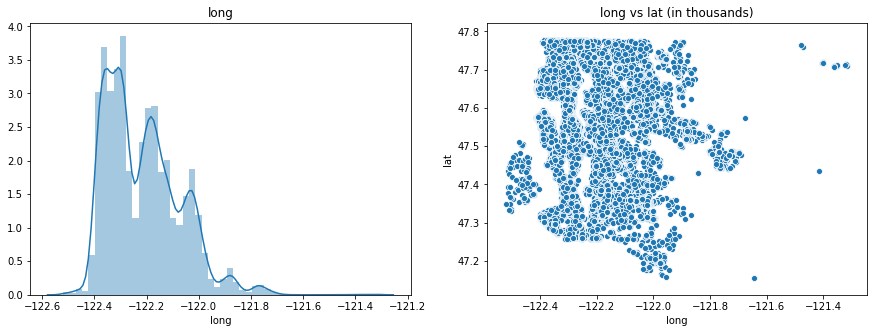

In [46]:
check_column(df['long'], df['lat'], nbins = 5)

In [47]:
# Well look at that, it's basically a map of Seattle and the surrounding areas. The histogram even
# seems to represent the density of Seattle and the dropoff to the east. So latitude and longitude could
# be indicators of where these locations fall within that area. Could actually be very useful
# if the numbers can be carved up in a meaninful way! But we'd have to attack it in a way that used multiple
# variables at once. Sounds scomplicated, if only there were a way to do that.....

---------------------------------------------------------------------------
series dtype is float64

- Unique Values for lat


(47.622, 47.778]    8578
(47.467, 47.622]    7725
(47.311, 47.467]    4179
(47.154, 47.311]    1115
Name: lat, dtype: int64

n- Null Values 
0

	Describe
count    21597.000000
mean        47.560093
std          0.138552
min         47.155900
25%         47.471100
50%         47.571800
75%         47.678000
max         47.777600
Name: lat, dtype: float64


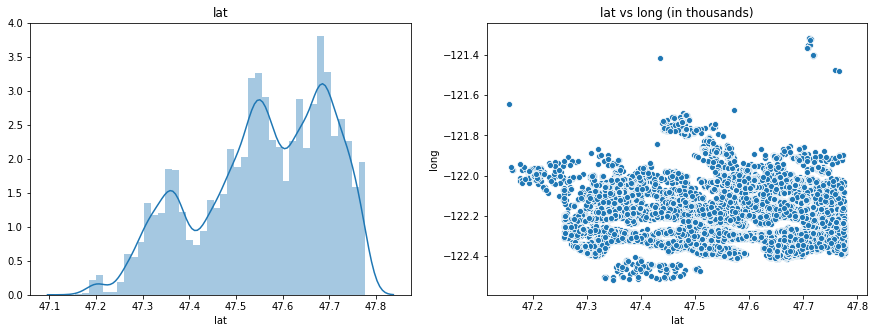

In [48]:
check_column(df['lat'], df['long'], nbins = 4)

In [49]:
df[df['long'] > -121.7]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2587,5/8/2014,134.00,2,1.50,980,5000,2.0,0.0,3,7,980,0.0,1922,2003.0,98014,47.7076,-121.359,1040,5000
2845,10/20/2014,724.95,4,3.50,3010,174240,2.0,0.0,3,9,3010,0.0,2004,0.0,98045,47.4775,-121.691,2720,247856
2925,4/30/2015,167.00,1,1.00,780,10235,1.5,0.0,3,6,780,0.0,1989,NaN,98014,47.7130,-121.315,930,10165
3292,6/24/2014,380.00,3,2.25,1860,15559,2.0,0.0,4,7,1860,0.0,1963,0.0,98022,47.1559,-121.646,1110,11586
4199,7/9/2014,150.00,3,0.75,490,38500,1.5,0.0,4,5,490,0.0,1959,0.0,98014,47.7112,-121.315,800,18297
4844,5/21/2014,525.00,3,2.75,2100,10362,2.0,0.0,3,9,1510,590.0,1998,0.0,98045,47.4347,-121.417,2240,11842
5861,8/5/2014,175.00,2,1.75,1050,9800,1.5,0.0,4,6,1050,0.0,1975,0.0,98019,47.7595,-121.473,1230,12726
6083,4/16/2015,150.00,3,1.00,890,6488,1.5,0.0,3,5,890,0.0,1928,0.0,98014,47.7087,-121.352,1330,16250
6464,6/26/2014,320.00,3,2.00,1550,34175,1.5,0.0,3,7,1550,0.0,1999,0.0,98045,47.4855,-121.698,2300,35174
10084,11/11/2014,200.00,2,1.75,1320,13052,1.5,0.0,3,7,1320,0.0,1980,0.0,98014,47.7120,-121.352,1320,13052


In [50]:
# I decided late in the game to start using longitude. Since there are some 
# clear outliers, I'll cut those rows completely.

In [51]:
df['long'].head()

0   -122.257
1   -122.319
2   -122.233
3   -122.393
4   -122.045
Name: long, dtype: float64

In [52]:
df = df[df['long'] < -121.7]

In [53]:
df

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,10/13/2014,221.900,3,1.00,1180,5650,1.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,12/9/2014,538.000,3,2.25,2570,7242,2.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,2/25/2015,180.000,2,1.00,770,10000,1.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,12/9/2014,604.000,4,3.00,1960,5000,1.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,2/18/2015,510.000,3,2.00,1680,8080,1.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
5,5/12/2014,1230.000,4,4.50,5420,101930,1.0,0.0,3,11,3890,1530.0,2001,0.0,98053,47.6561,-122.005,4760,101930
6,6/27/2014,257.500,3,2.25,1715,6819,2.0,0.0,3,7,1715,?,1995,0.0,98003,47.3097,-122.327,2238,6819
7,1/15/2015,291.850,3,1.50,1060,9711,1.0,0.0,3,7,1060,0.0,1963,0.0,98198,47.4095,-122.315,1650,9711
8,4/15/2015,229.500,3,1.00,1780,7470,1.0,0.0,3,7,1050,730.0,1960,0.0,98146,47.5123,-122.337,1780,8113
9,3/12/2015,323.000,3,2.50,1890,6560,2.0,0.0,3,7,1890,0.0,2003,0.0,98038,47.3684,-122.031,2390,7570


---------------------------------------------------------------------------
series dtype is int64

- Unique Values for zipcode


(98020.8, 98040.6]              4379
(98100.0, 98119.8]              4257
(98040.6, 98060.4]              3336
(98000.80099999999, 98020.8]    2840
(98119.8, 98139.6]              1809
(98060.4, 98080.2]              1695
(98139.6, 98159.4]              1134
(98159.4, 98179.2]              1040
(98179.2, 98199.0]               733
(98080.2, 98100.0]               351
Name: zipcode, dtype: int64

n- Null Values 
0

	Describe
count    21574.000000
mean     98078.009641
std         53.509978
min      98001.000000
25%      98033.000000
50%      98065.000000
75%      98118.000000
max      98199.000000
Name: zipcode, dtype: float64


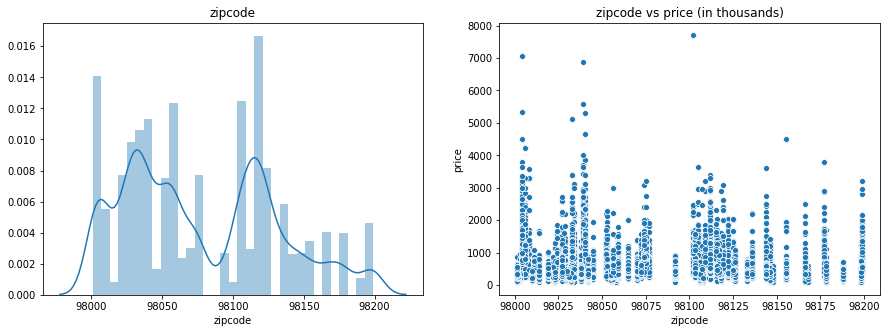

In [54]:
# I want to get rid of zipcode, but I want to check it out first to make sure there's nothing interesting.
check_column(df['zipcode'], df['price'], nbins = 10)

---------------------------------------------------------------------------
series dtype is int64

- Unique Values for bedrooms


3     9811
4     6881
2     2753
5     1601
6      272
1      194
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

n- Null Values 
0

	Describe
count    21574.000000
mean         3.374061
std          0.926125
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         33.000000
Name: bedrooms, dtype: float64


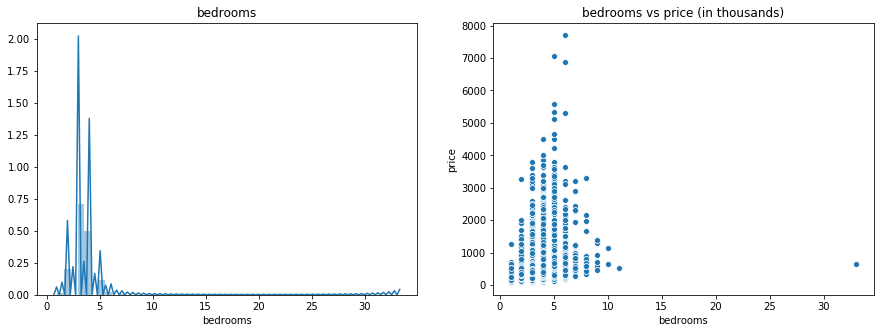

In [55]:
# What's going on with bedrooms?
check_column(df.bedrooms, df['price'])

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21574 entries, 0 to 21596
Data columns (total 19 columns):
date             21574 non-null object
price            21574 non-null float64
bedrooms         21574 non-null int64
bathrooms        21574 non-null float64
sqft_living      21574 non-null int64
sqft_lot         21574 non-null int64
floors           21574 non-null float64
waterfront       21574 non-null float64
condition        21574 non-null int64
grade            21574 non-null int64
sqft_above       21574 non-null int64
sqft_basement    21574 non-null object
yr_built         21574 non-null int64
yr_renovated     17736 non-null float64
zipcode          21574 non-null int64
lat              21574 non-null float64
long             21574 non-null float64
sqft_living15    21574 non-null int64
sqft_lot15       21574 non-null int64
dtypes: float64(7), int64(10), object(2)
memory usage: 3.3+ MB


In [57]:
# Looks like one outlier. See you in hell, 33 bedroom house, if a 33 bedroom house in fact you are.
df[df.bedrooms > 30]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15856,6/25/2014,640.0,33,1.75,1620,6000,1.0,0.0,5,7,1040,580.0,1947,0.0,98103,47.6878,-122.331,1330,4700


In [58]:
df = df[df.bedrooms < 30]
df[df.bedrooms > 30]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


---------------------------------------------------------------------------
series dtype is int64

- Unique Values for bedrooms


3     9811
4     6881
2     2753
5     1601
6      272
1      194
7       38
8       13
9        6
10       3
11       1
Name: bedrooms, dtype: int64

n- Null Values 
0

	Describe
count    21573.000000
mean         3.372688
std          0.903913
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         11.000000
Name: bedrooms, dtype: float64


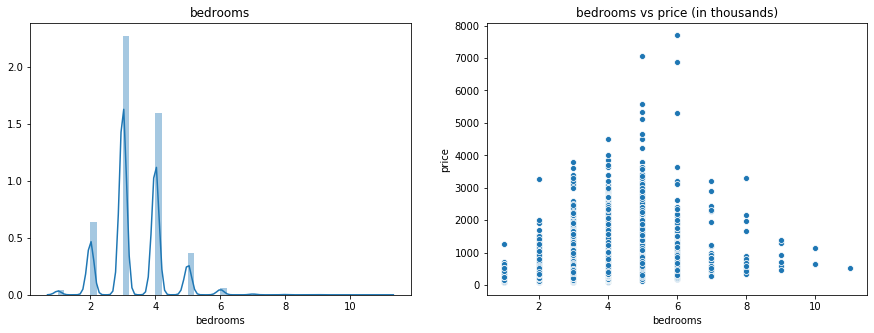

In [59]:
# Yeah that 1620 sqft house with 33 bedrooms can just get the hell off my dataframe. Let's try that graph again:
check_column(df.bedrooms, df['price'])

In [60]:
# pd.plotting.scatter_matrix(df, figsize=(20,20));

# Commenting out this second scatter matrix. I don't think I need it for now.
# And these things take forever to run. There are only so many cups of tea
# I want to go get while I wait for it to run.

---------------------------------------------------------------------------
series dtype is int64

- Unique Values for yr_built


(2005.8, 2010.4]      1608
(2001.2, 2005.8]      1521
(1964.4, 1969.0]      1446
(1973.6, 1978.2]      1407
(1987.4, 1992.0]      1297
(1950.6, 1955.2]      1247
(1959.8, 1964.4]      1210
(1996.6, 2001.2]      1200
(1982.8, 1987.4]      1177
(2010.4, 2015.0]      1097
(1955.2, 1959.8]       953
(1946.0, 1950.6]       940
(1978.2, 1982.8]       886
(1992.0, 1996.6]       813
(1941.4, 1946.0]       754
(1923.0, 1927.6]       599
(1936.8, 1941.4]       543
(1969.0, 1973.6]       533
(1918.4, 1923.0]       440
(1927.6, 1932.2]       428
(1904.6, 1909.2]       411
(1913.8, 1918.4]       373
(1909.2, 1913.8]       343
(1899.884, 1904.6]     233
(1932.2, 1936.8]       114
Name: yr_built, dtype: int64

n- Null Values 
0

	Describe
count    21573.000000
mean      1970.996477
std         29.370825
min       1900.000000
25%       1951.000000
50%       1975.000000
75%       1997.000000
max       2015.000000
Name: yr_built, dtype: float64


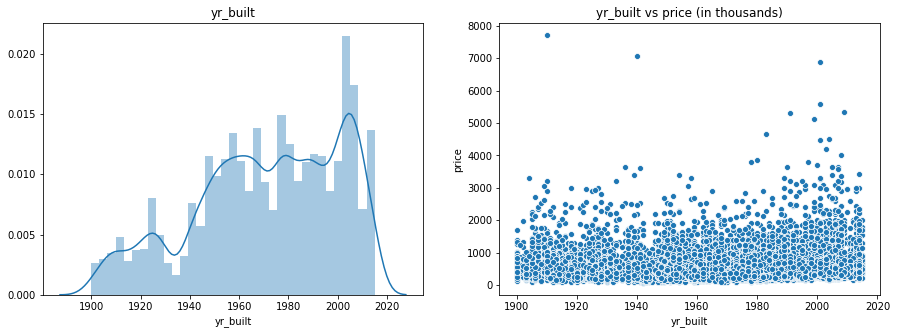

In [61]:
check_column(df['yr_built'], df['price'], nbins = 25)

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21573 entries, 0 to 21596
Data columns (total 19 columns):
date             21573 non-null object
price            21573 non-null float64
bedrooms         21573 non-null int64
bathrooms        21573 non-null float64
sqft_living      21573 non-null int64
sqft_lot         21573 non-null int64
floors           21573 non-null float64
waterfront       21573 non-null float64
condition        21573 non-null int64
grade            21573 non-null int64
sqft_above       21573 non-null int64
sqft_basement    21573 non-null object
yr_built         21573 non-null int64
yr_renovated     17735 non-null float64
zipcode          21573 non-null int64
lat              21573 non-null float64
long             21573 non-null float64
sqft_living15    21573 non-null int64
sqft_lot15       21573 non-null int64
dtypes: float64(7), int64(10), object(2)
memory usage: 3.3+ MB


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21573 entries, 0 to 21596
Data columns (total 19 columns):
date             21573 non-null object
price            21573 non-null float64
bedrooms         21573 non-null int64
bathrooms        21573 non-null float64
sqft_living      21573 non-null int64
sqft_lot         21573 non-null int64
floors           21573 non-null float64
waterfront       21573 non-null float64
condition        21573 non-null int64
grade            21573 non-null int64
sqft_above       21573 non-null int64
sqft_basement    21573 non-null object
yr_built         21573 non-null int64
yr_renovated     17735 non-null float64
zipcode          21573 non-null int64
lat              21573 non-null float64
long             21573 non-null float64
sqft_living15    21573 non-null int64
sqft_lot15       21573 non-null int64
dtypes: float64(7), int64(10), object(2)
memory usage: 3.3+ MB


## Final Scatters for last check

---------------------------------------------------------------------------
series dtype is int64

- Unique Values for sqft_living


(356.829, 6955.0]    21543
(6955.0, 13540.0]       30
Name: sqft_living, dtype: int64

n- Null Values 
0

	Describe
count    21573.000000
mean      2080.948222
std        918.204413
min        370.000000
25%       1430.000000
50%       1910.000000
75%       2550.000000
max      13540.000000
Name: sqft_living, dtype: float64
---------------------------------------------------------------------------
series dtype is int64

- Unique Values for grade


(2.9890000000000003, 8.0]    17326
(8.0, 13.0]                   4247
Name: grade, dtype: int64

n- Null Values 
0

	Describe
count    21573.000000
mean         7.658786
std          1.172877
min          3.000000
25%          7.000000
50%          7.000000
75%          8.000000
max         13.000000
Name: grade, dtype: float64
---------------------------------------------------------------------------
series dtype is int64

- Unique Values for bedrooms


(0.989, 6.0]    21512
(6.0, 11.0]        61
Name: bedrooms, dtype: int64

n- Null Values 
0

	Describe
count    21573.000000
mean         3.372688
std          0.903913
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         11.000000
Name: bedrooms, dtype: float64
---------------------------------------------------------------------------
series dtype is float64

- Unique Values for waterfront


(-0.002, 0.5]    21427
(0.5, 1.0]         146
Name: waterfront, dtype: int64

n- Null Values 
0

	Describe
count    21573.000000
mean         0.006768
std          0.081989
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: waterfront, dtype: float64
---------------------------------------------------------------------------
series dtype is float64

- Unique Values for lat


(47.468, 47.778]    16244
(47.158, 47.468]     5329
Name: lat, dtype: int64

n- Null Values 
0

	Describe
count    21573.000000
mean        47.560008
std          0.138524
min         47.159300
25%         47.470800
50%         47.571800
75%         47.677900
max         47.777600
Name: lat, dtype: float64


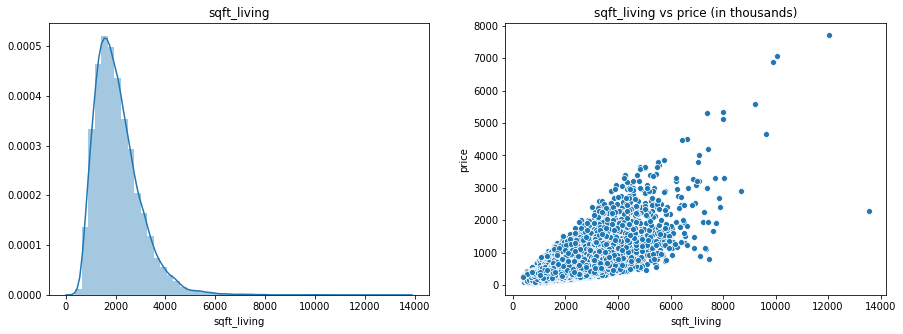

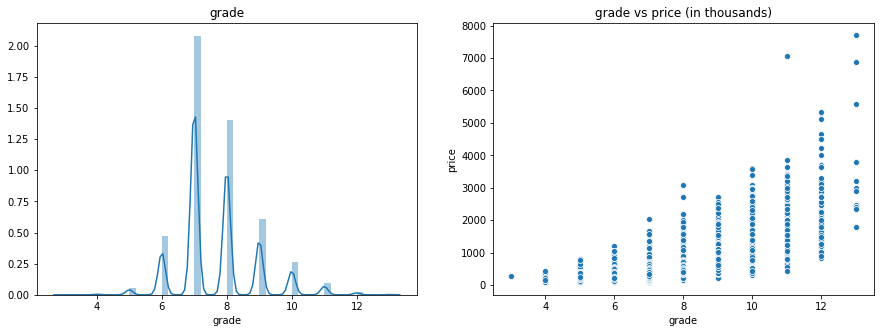

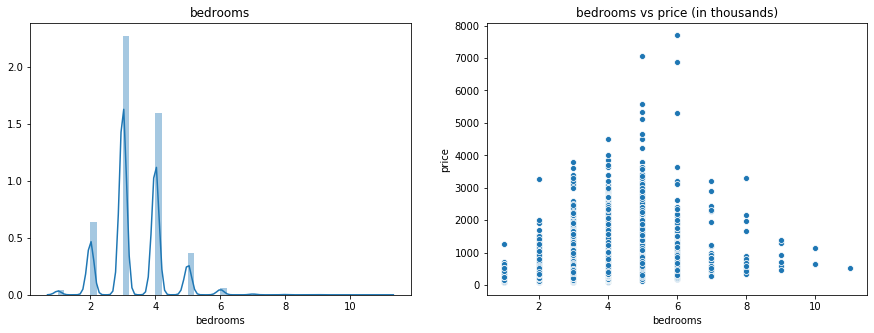

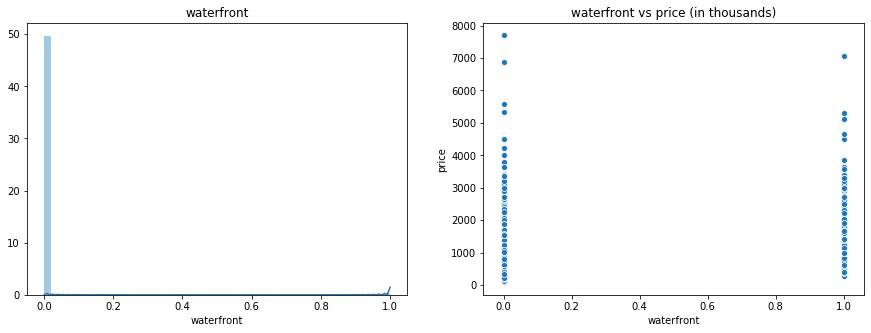

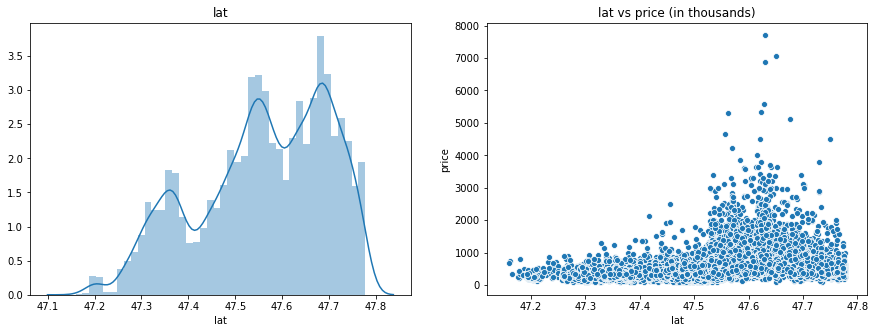

In [64]:
check_column(df['sqft_living'], df['price'], nbins = 2)
check_column(df['grade'], df['price'], nbins = 2)
check_column(df['bedrooms'], df['price'], nbins = 2)
check_column(df['waterfront'], df['price'], nbins = 2)
check_column(df['lat'], df['price'], nbins = 2)

# MODEL

## 1st Model Attempt

In [65]:
# All right, we've got some holes in our work up to this point but let's make a f*&@ing model
# and see what happens.

In [66]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [67]:
it_1_predictors = df[['sqft_living', 'waterfront', 'bedrooms']]
formula = 'price~sqft_living+C(waterfront)+bedrooms'

In [68]:
model_1 = ols(formula = formula, data = df).fit()

In [69]:
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     8488.
Date:                Sun, 27 Oct 2019   Prob (F-statistic):               0.00
Time:                        23:41:09   Log-Likelihood:            -1.4962e+05
No. Observations:               21573   AIC:                         2.993e+05
Df Residuals:                   21569   BIC:                         2.993e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               86.8337      6.547     13.262      0.000      74.000      99.667
C(waterfront)[T.1.0]   825.2337     20.846     39.587      0.000     784.374     866.093
sqft_living              0.3056      0.002    132.216      0.000       0.301       0.310
bedrooms               -55.7043      2.335    -23.853      0.000     -60.282     -51.127
==============================================================================
Omnibus:                    12985.427   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           389153.728
Skew:                           2.382   Prob(JB):                         0.00
Kurtosis:                      23.254   Cond. No.                     2.80e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [70]:
# Does it work?

def predict_value(sqft_living = None, waterfront = None, bedrooms = None):
    if not sqft_living:
        sqft_living = df['sqft_living'].mean()
    if not waterfront:
        waterfront = 0
#     if not lat:
#         lat = df['lat'].mean()
    if not bedrooms:
        bedrooms = 3
    return (86.2416) + (0.3056*sqft_living) + (	825.3999*waterfront) + (-55.5479*bedrooms)

estimated_price = predict_value(sqft_living = 2000, waterfront = 1, bedrooms = 5)
print(estimated_price)


# I had to pull out the lat value to make this work. Knowing I had wanted to run this without standardization etc.,
# it looks like the lat value threw everything off and gave me a negative outcome. So I'll work
# on standardization in the next interation, and hopefully that value will work.

# Update: I must have done something wrong in the formula that first time becuase it works fine now. 

# Update to the update: Actually I had failed to update the coef for lat, giving me a falsse sense of security.
# It is in fact problematic.

1245.1019999999999


## 2nd Model Attempt
That first one had two clear problems: The latitude value had not been standardized, 
and I haven't figured out how to deal with the 0 or 1 value of the waterfront. As it stands, 
though the R^2 value is higher, the real-world testing proves problematic because it greatly over-estimates
the value of a home on the water.

Or does it....

In [71]:
df[df['waterfront'] == 1]['price'].mean()

1717.214726027397

In [72]:
df[df['waterfront'] == 0]['price'].mean()

532.5438277873677

In [73]:
# Something funny going on with the bedrooms value. When I increase it, the home
# value goes down. Will remove them for now.

In [74]:
upper_outliers(df['bedrooms'])

Mean feature value is: 3.37
2x standard deviation cutoff: 5.18
Records above 2x standard deviation: 333
Percent of records above 2x standard deviation: 0.02


In [75]:
# df['bedrooms'] = cut_upper_outliers(df['bedrooms'], 3)

In [76]:
# I stand corrected! People do love their waterfront views. I guess my previous model was actually not 
# as bad as I thought.
# Sweet.

In [77]:
lat_minmax = (df['lat'] - min(df['lat'])) / (max(df['lat']) - min(df['lat']))
latmax = df['lat'].max()
latmin = df['lat'].min()
long_minmax = (df['long'] - min(df['long'])) / (max(df['long']) - min(df['long']))
longmax = df['long'].max()
longmin = df['long'].min()

In [78]:
# Before I mess with the database, I need to capture the old values because 
# I'm going to need them later.
# legacy_latmax = df['lat'].max()
# legacy_latmin = df['lat'].min()
# print(original_latmax)

In [79]:
age = 2019 - df['yr_built']
it_2_predictors = df[['sqft_living', 'waterfront', 'bedrooms']]
rfe_predictors = pd.concat([it_2_predictors, df['grade'], df['bathrooms'],
                            lat_minmax, long_minmax, age], axis = 1)
it_2_predictors = pd.concat([it_1_predictors, lat_minmax, long_minmax, df['price']], axis = 1)
formula = 'price~sqft_living+C(waterfront)+bedrooms+lat_minmax+long_minmax'

In [80]:
df['price'].head()

0    221.9
1    538.0
2    180.0
3    604.0
4    510.0
Name: price, dtype: float64

In [81]:
model_2 = ols(formula = formula, data = it_2_predictors).fit()

In [82]:
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     7145.
Date:                Sun, 27 Oct 2019   Prob (F-statistic):               0.00
Time:                        23:41:09   Log-Likelihood:            -1.4749e+05
No. Observations:               21573   AIC:                         2.950e+05
Df Residuals:                   21567   BIC:                         2.950e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             -122.6135      8.191    -14.969      0.000    -138.668    -106.559
C(waterfront)[T.1.0]   819.9309     18.941     43.289      0.000     782.806     857.056
sqft_living              0.3070      0.002    142.352      0.000       0.303       0.311
bedrooms               -49.2877      2.119    -23.255      0.000     -53.442     -45.133
lat_minmax             415.3238      6.965     59.626      0.000     401.671     428.977
long_minmax           -226.1366      9.510    -23.779      0.000    -244.777    -207.496
==============================================================================
Omnibus:                    14913.066   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           676537.360
Skew:                           2.782   Prob(JB):                         0.00
Kurtosis:                      29.864   Cond. No.                     2.81e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.81e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [83]:
def predict_value(sqft_living = None, waterfront = None, bedrooms = None, lat = None):
    if not sqft_living:
        sqft_living = df['sqft_living'].mean()
    if not waterfront:
        waterfront = 0
    if not lat:
        lat = df['lat'].mean()
    else:
        lat = (lat - original_latmin) / (original_latmax - original_latmin)
#         print((lat - legacy_latmin) / (legacy_latmax - legacy_latmin))
#         print(df2['lat'].max())
        print(lat)
    if not bedrooms:
        bedrooms = 3
    print(lat)
    return ((-201.9622) + (0.2964*sqft_living) + (851.1191*waterfront) +
            (-49.8772*bedrooms) + (442.7264*lat))
#     return ((86.2416) + (0.3056*sqft_living) + (825.3999*waterfront) +
#             (-55.5479*bedrooms) + (-206.1311*lat))

estimated_price = predict_value(sqft_living = 3000, waterfront = 0, bedrooms = 5, lat = 47.5)
print(estimated_price)
# estimated_price = predict_value(sqft_living = 1180, waterfront = 0,
#                                 bathrooms = 1, bedrooms = 3,
#                                lat = 47.5112)
print(estimated_price)

# lat_minmax = (df['lat'] - min(df['lat'])) / (max(df['lat']) - min(df['lat']))

# I had to pull out the lat value to make this work. Knowing I had wanted to run this without standardization etc.,
# it looks like the lat value threw everything off and gave me a negative outcome. So I'll work
# on standardization in the next interation, and hopefully that value will work.

# Update: I must have done something wrong in the formula that first time becuase it works fine now. 

# Update to the update: Actually I had failed to update the coef for lat, giving me a falsse sense of security.
# It is in fact problematic.

0.5534823870033763
0.5534823870033763
682.8930646614117
682.8930646614117


In [84]:
# Now that we have two attempts done, I'm going for recursive feature 
# elimination to better guide my efforts.

In [85]:
rfe_predictors.head()

,sqft_living,waterfront,bedrooms,grade,bathrooms,lat,long,yr_built
0,1180,0.0,3,7,1.00,0.569141,0.320293,64
1,2570,0.0,3,7,2.25,0.908459,0.244499,68
2,770,0.0,2,6,1.00,0.935792,0.349633,86
3,1960,0.0,4,7,3.00,0.584668,0.154034,54
4,1680,0.0,3,8,2.00,0.739932,0.579462,32


In [86]:
#from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression


linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select=3)
selector = selector.fit(rfe_predictors, df['price'])

In [87]:
selector.support_ 

array([False,  True, False,  True, False,  True, False, False])

In [88]:
selector.ranking_

array([6, 1, 5, 1, 3, 1, 2, 4])

In [89]:
estimators = selector.estimator_
print(estimators.coef_)
print(estimators.intercept_)

[966.5231693  195.06316958 391.84968282]
-1213.8767983737393


## 3rd Model Attempt

Going to play with adding and maybe changing some of the variables

In [90]:
# # logsqft = np.log(df['sqft_living'])
# # grade = df['grade']
# # bathrooms = np.log(df['bathrooms'])
# # bedrooms = np.log(df['bedrooms'])

# logsqft = df['sqft_living']
# grade = df['grade']
# bathrooms = df['bathrooms']
# bedrooms = df['bedrooms']


# lat_minmax = (df['lat'] - min(df['lat'])) / (max(df['lat']) - min(df['lat']))
# waterfront = df['waterfront']

# scaled_sqft_living = (logsqft - np.mean(logsqft)) / np.sqrt(np.var(logsqft))



# data_3['price'] = df['price']

data_3 = pd.DataFrame([])
data_3['price'] = df['price']
data_3['sqft_living'] = df['sqft_living']
data_3['grade'] = df['price']
data_3['bathrooms'] = df['bathrooms']
data_3['bedrooms'] = df['bedrooms']
data_3['lat'] = lat_minmax
data_3['long'] = long_minmax
data_3['waterfront'] = df['waterfront']
data_3['grade'] = df['grade']
data_3['age'] = 2019 - df['yr_built']

In [91]:
# it_3_predictors = df[['price', 'sqft_living', 'grade', 'bathrooms', 'bedrooms', 'lat', 'waterfront']]
formula = 'price~lat+C(waterfront)+grade+sqft_living+long'

In [92]:
model_3 = ols(formula = formula, data = data_3).fit()

In [93]:
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     7874.
Date:                Sun, 27 Oct 2019   Prob (F-statistic):               0.00
Time:                        23:41:09   Log-Likelihood:            -1.4683e+05
No. Observations:               21573   AIC:                         2.937e+05
Df Residuals:                   21567   BIC:                         2.937e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             -698.8210     12.300    -56.813      0.000    -722.931    -674.711
C(waterfront)[T.1.0]   847.9297     18.304     46.325      0.000     812.052     883.807
lat                    388.0156      6.793     57.116      0.000     374.700     401.331
grade                   87.2835      1.978     44.131      0.000      83.407      91.160
sqft_living              0.1940      0.003     76.360      0.000       0.189       0.199
long                  -241.9401      9.231    -26.210      0.000    -260.033    -223.847
==============================================================================
Omnibus:                    17553.371   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1351133.295
Skew:                           3.405   Prob(JB):                         0.00
Kurtosis:                      41.168   Cond. No.                     2.80e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The below formula takes in values to pridict a house price based on the
following features:
    Square feet of living space
    Waterfront
    Grade
    Number of bedrooms
    Latitude

In [94]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select=4)
selector = selector.fit(rfe_predictors, data_3['price'])

In [95]:
selector.support_ 

array([False,  True, False,  True, False,  True,  True, False])

In [96]:
selector.ranking_

array([5, 1, 4, 1, 2, 1, 1, 3])

In [97]:
estimators = selector.estimator_
print(estimators.coef_)
print(estimators.intercept_)

[ 949.07720907  199.86393854  373.57985972 -142.98088335]
-1185.5125973568247


In [98]:
data_3.head()

,price,sqft_living,grade,bathrooms,bedrooms,lat,long,waterfront,age
0,221.9,1180,7,1.00,3,0.569141,0.320293,0.0,64
1,538.0,2570,7,2.25,3,0.908459,0.244499,0.0,68
2,180.0,770,6,1.00,2,0.935792,0.349633,0.0,86
3,604.0,1960,7,3.00,4,0.584668,0.154034,0.0,54
4,510.0,1680,8,2.00,3,0.739932,0.579462,0.0,32


## 4th Model Attempt

In [99]:
# formula = 'price~lat+C(waterfront)+grade+sqft_living'
formula = 'price~grade+bedrooms+lat+long+waterfront'

In [100]:
model_1 = ols(formula = formula, data = data_3).fit()

In [101]:
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     5507.
Date:                Sun, 27 Oct 2019   Prob (F-statistic):               0.00
Time:                        23:41:10   Log-Likelihood:            -1.4916e+05
No. Observations:               21573   AIC:                         2.983e+05
Df Residuals:                   21567   BIC:                         2.984e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1240.8703     11.973   -103.636      0.000   -1264.339   -1217.402
grade        187.4420      1.568    119.520      0.000     184.368     190.516
bedrooms      44.7122      1.980     22.584      0.000      40.832      48.593
lat          381.4494      7.573     50.369      0.000     366.606     396.293
long        -157.7875     10.202    -15.466      0.000    -177.785    -137.790
waterfront   963.9531     20.348     47.373      0.000     924.069    1003.837
==============================================================================
Omnibus:                    20450.623   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2667892.959
Skew:                           4.205   Prob(JB):                         0.00
Kurtosis:                      56.827   Cond. No.                         105.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [102]:
data_3.columns

Index(['price', 'sqft_living', 'grade', 'bathrooms', 'bedrooms', 'lat', 'long',
       'waterfront', 'age'],
      dtype='object')

Going backward on the R^2 number, now. Throwing in the towel.

# iNTERPRET

Below is a function that takes in housing attributes and predicts the value for Kings County homes.

In [103]:
def predict_value(sqft_living = None, grade = None, bathrooms = None, 
                  bedrooms = None, lat = None, long = None, waterfront = None, 
                  age = None):
    if not sqft_living:
        sqft_living = df['sqft_living'].mean()
    if not age:
        age = data_3['age'].mean()
    if not waterfront:
        waterfront = 0
    if not lat:
        lat = df['lat'].mean()
    if not bedrooms:
        bedrooms = 3
    if not bathrooms:
        bathrooms = 3
    if not grade:
        grade = 3
    if not lat:
        lat = df['lat'].mean()
    lat = (lat - latmin) / (latmax - latmin)
    if not long:
        long = df['long'].mean()
    long = (long - longmin) / (longmax - longmin)
    return round(((-698.8210) + (0.1940*sqft_living) +
            (848.5464*waterfront) + (87.2835*grade) +
            (388.0156*lat) + (-241.9401*long)), 2)

In [104]:
df[df['waterfront'] > 0]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
49,3/11/2015,1350.0,3,2.50,2753,65005,1.0,1.0,5,9,2165,588.0,1953,0.0,98070,47.4041,-122.451,2680,72513
230,4/13/2015,655.0,2,1.75,1450,15798,2.0,1.0,3,7,1230,220.0,1915,1978.0,98166,47.4497,-122.375,2030,13193
246,9/29/2014,2400.0,4,2.50,3650,8354,1.0,1.0,3,9,1830,1820.0,2000,0.0,98074,47.6338,-122.072,3120,18841
264,10/27/2014,369.9,1,0.75,760,10079,1.0,1.0,5,5,760,0.0,1936,0.0,98070,47.4683,-122.438,1230,14267
300,6/24/2014,3080.0,4,5.00,4550,18641,1.0,1.0,3,10,2600,1950.0,2002,0.0,98074,47.6053,-122.077,4550,19508
457,11/26/2014,705.0,3,3.00,1970,20978,2.0,1.0,4,9,1770,200.0,1980,0.0,98070,47.3844,-122.438,2280,75396
540,2/18/2015,2130.0,3,2.50,5403,24069,2.0,1.0,4,12,5403,0.0,1976,0.0,98166,47.4169,-122.348,3980,104374
656,11/20/2014,3070.0,3,2.50,3930,55867,1.0,1.0,4,8,2330,1600.0,1957,0.0,98034,47.7022,-122.224,2730,26324
1080,8/27/2014,825.0,2,1.00,1150,12775,1.0,1.0,4,6,1150,0.0,1908,0.0,98178,47.5020,-122.222,2440,11852
1150,4/21/2015,1960.0,4,2.75,3120,7898,1.0,1.0,4,8,1560,1560.0,1963,NaN,98034,47.7165,-122.259,2630,13868


In [106]:
prediction = input("Enter prediction? Y/N ")

if prediction == 'Y' or prediction == 'y':
    sqft_input = input('Square Feet: ')
    water_input = input('Waterfront? Y/N ')
    grade_input = input('Grade ')
    lat_input = input('Latitude ')
    long_input = input('Longitude')
    if water_input == 'Y' or water_input == 'y':
        water_input = 1
    else:
        water_input = 0
    estimated_price = predict_value(sqft_living = float(sqft_input),
                                   waterfront = water_input, grade =
                                   float(grade_input), lat = float(lat_input), 
                                   long = float(long_input))
    if estimated_price < 1000:
        estimated_price = int(estimated_price)
        estimated_price = '$' + str(estimated_price) + 'k'
    else:
        estimated_price = round(estimated_price / 1000, 1)
        estimated_price = '$' + str(estimated_price) + 'M'
    print(estimated_price)
else:
    print('OK then')
    

Enter prediction? Y/N Y
Square Feet: 3540
Waterfront? Y/N Y
Grade 10
Latitude 47.5943
Longitude-122.110
$1.9M


# CONCLUSIONS & RECOMMENDATIONS

Don't move to Seattle. The homes are expensive and the weather is crummy.

It may not be surprising that homes on the waterfront are more valuable than those that aren't. But what our latitude feature also shows is that homes that are closer to the water also benefit, in a linear way from east to west. 

Additional bedrooms and bathrooms have diminishing returns. Overall square footage is a superior predictor of value than number of rooms.